# Overview

This notebook is used to develop a function that can perform image transformation based on given reference points.

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import cv2

from scipy.ndimage import affine_transform
from scipy.ndimage import gaussian_filter

from tomoproc.prep.detection import detect_slit_corners
from tomoproc.prep.detection import guess_slit_box
from tomoproc.util.npmath    import calc_affine_transform
from tomoproc.util.npmath    import discrete_cdf

from tqdm import tqdm_notebook

# Testing with random data

In [2]:
cnrs_src = np.array([
    (351.66000986150334, 457.24552112467825), 
    (1067.8318918540397, 457.93847724779715), 
    (1063.640283201428, 1329.4255491183026), 
    (347.4835907705821, 1328.413135716564),
])

cnrs_tgt_shift = cnrs_src + np.array([10, 1]) 

cnrs_tgt = cnrs_tgt_shift + np.random.random((4, 2))*5

In [3]:
def get_transformation(pts_src, pts_tgt):
    m = np.zeros((2, 3))
    # get translation
    cnt_src = np.average(pts_src, axis=0)
    cnt_tgt = np.average(pts_tgt, axis=0)
    
    m[:,-1] = (cnt_tgt - cnt_src).T   
    
    # get the rotation
    pts_src = pts_src - cnt_src 
    pts_tgt = pts_tgt - cnt_tgt

    m[:2,:2] = sp.linalg.lstsq(pts_src, pts_tgt)[0].T
    
    return m

In [4]:
print(get_transformation(cnrs_src, cnrs_tgt_shift))

print(calc_affine_transform(cnrs_src, cnrs_tgt_shift)[:2,:])

m = cv2.getAffineTransform(cnrs_src.astype(np.float32)[:3,:], cnrs_tgt_shift.astype(np.float32)[:3,:])
print(m)

[[ 1.00000000e+00 -1.22322132e-17  1.00000000e+01]
 [-2.24257242e-17  1.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00 -2.86088219e-15  1.00000000e+01]
 [-1.06794329e-16  1.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  1.70984408e-16  1.00000000e+01]
 [-8.52552609e-18  1.00000000e+00  1.00000000e+00]]


In [5]:
print(get_transformation(cnrs_src, cnrs_tgt))

print(calc_affine_transform(cnrs_src, cnrs_tgt)[:2,:])

m = cv2.getAffineTransform(cnrs_src.astype(np.float32)[:3,:], cnrs_tgt.astype(np.float32)[:3,:])
print(m)

[[ 9.99138477e-01 -3.52625540e-03  1.28849102e+01]
 [ 1.66002964e-03  1.00218531e+00  2.64295039e+00]]
[[ 9.99138477e-01 -3.52625540e-03  1.66444178e+01]
 [ 1.66002964e-03  1.00218531e+00 -4.83818969e-01]]
[[ 1.00084933e+00 -4.92264221e-03  1.60690003e+01]
 [ 1.62836936e-03  1.00221112e+00 -4.73152182e-01]]


# Testing with synthetic data

In [6]:
cnrs = np.array([
    [2, 1],
    [-2, 1],
    [-2, -1],
    [2, -1],
])

theta = np.radians(10)
rot = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)],
])
cnrs_rotted = np.dot(rot, cnrs.T).T

trns = np.random.random((1, 2))*0.2
cnrs_rotted_shiftted = cnrs_rotted + trns

level = 0.01  # 1% of noise
noise = np.random.random(cnrs.shape)*level
cnrs_tgt = cnrs_rotted_shiftted + noise

In [7]:
print(f"perfect:\n{cnrs}\n")

print(f"rotated:\n{cnrs_rotted}\n")

print(f"rotated&shifted:\n{cnrs_rotted_shiftted}\n")

print(f"recorded:\n{cnrs_tgt}")

perfect:
[[ 2  1]
 [-2  1]
 [-2 -1]
 [ 2 -1]]

rotated:
[[ 1.79596733  1.33210411]
 [-2.14326368  0.6375114 ]
 [-1.79596733 -1.33210411]
 [ 2.14326368 -0.6375114 ]]

rotated&shifted:
[[ 1.94499261  1.34823991]
 [-1.9942384   0.6536472 ]
 [-1.64694205 -1.3159683 ]
 [ 2.29228897 -0.62137559]]

recorded:
[[ 1.94985993  1.3512403 ]
 [-1.98619973  0.65847893]
 [-1.64662576 -1.3085719 ]
 [ 2.30090802 -0.61415299]]


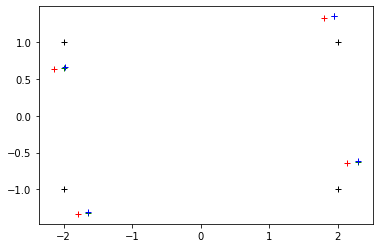

In [8]:
plt.plot(cnrs[:,0], cnrs[:,1], 'k+')

plt.plot(cnrs_rotted[:,0], cnrs_rotted[:,1], 'r+')

plt.plot(cnrs_rotted_shiftted[:,0], cnrs_rotted_shiftted[:,1], 'g+')

plt.plot(cnrs_tgt[:,0], cnrs_tgt[:,1], 'b+')

evaluate the three methods to see which one provides the best resuts

In [9]:
# separated method

m_1 = get_transformation(cnrs, cnrs_tgt)
m_2 = calc_affine_transform(cnrs, cnrs_tgt)[:2, :]
m_3 = cv2.getAffineTransform(cnrs.astype(np.float32)[:3,:], cnrs_tgt.astype(np.float32)[:3,:])

print(f"step method:\n{m_1}")
print(f"least square:\n{m_2}")
print(f"open cv:\n{m_3}")

step method:
[[ 0.98544918 -0.17265552  0.15448562]
 [ 0.17339754  0.98311103  0.02174858]]
least square:
[[ 0.98544918 -0.17265552  0.15448562]
 [ 0.17339754  0.98311103  0.02174858]]
open cv:
[[ 0.98401493 -0.16978699  0.15161711]
 [ 0.17319034  0.98352543  0.02133417]]


In [10]:
theta_1 = np.arctan2(m_1[1,0], m_1[0,0])
theta_2 = np.arctan2(m_2[1,0], m_2[0,0])
theta_3 = np.arctan2(m_3[1,0], m_3[0,0])

trns_1 = m_1[:,-1].T
trns_2 = m_2[:,-1].T
trns_3 = m_3[:,-1].T

print("step method:")
print(f"{theta_1} - {theta} = {theta_1-theta}")
print(f"{trns_1} - {trns} = {trns_1-trns} ")

print("least square:")
print(f"{theta_2} - {theta} = {theta_2-theta}")
print(f"{trns_2} - {trns} = {trns_2-trns} ")

print("opencv:")
print(f"{theta_3} - {theta} = {theta_3-theta}")
print(f"{trns_3} - {trns} = {trns_3-trns} ")


step method:
0.17417491860974868 - 0.17453292519943295 = -0.0003580065896842677
[0.15448562 0.02174858] - [[0.14902528 0.01613581]] = [[0.00546033 0.00561278]] 
least square:
0.1741749186097487 - 0.17453292519943295 = -0.00035800658968423993
[0.15448562 0.02174858] - [[0.14902528 0.01613581]] = [[0.00546033 0.00561278]] 
opencv:
0.17421944639840406 - 0.17453292519943295 = -0.00031347880102888803
[0.15161711 0.02133417] - [[0.14902528 0.01613581]] = [[0.00259183 0.00519837]] 


So the single test case shows that the least square method we used before has a better chance of getting the rotation correct, whereas the opecv method has a better chance of getting the translation correct.

# Statistic analysis

Performing statistic analysis using synthetic data

## Ideal cases with no added noises

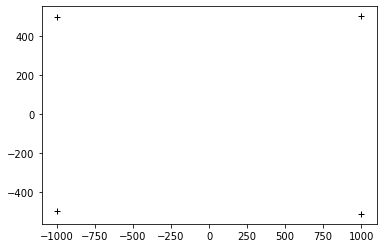

In [11]:
# mimic a 2k detector with imperfect slits

cnrs = np.array([
    [-1000, 500],
    [-998, -495],
    [1000, -510],
    [ 995,  502],
], dtype=float)

plt.plot(cnrs[:,0], cnrs[:,1], 'k+')

In [12]:
get_rotm = lambda theta: np.array([ 
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)],
])

print(get_rotm(np.pi/4))

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [13]:
N = 1000000  # total number of cases

thetas = np.radians((np.random.random(N)-0.5)*2*10)  # +- 10 degrees of rotation in detector drifting
trnls = (np.random.random((N, 2))-0.5)*2*10          # assume the detector will note drift more than 10 pixels

d_thetas_step = np.zeros(N)
d_thetas_lstq = np.zeros(N)
d_thetas_cv02 = np.zeros(N)

d_trnls_step = np.zeros((N,2))
d_trnls_lstq = np.zeros((N,2))
d_trnls_cv02 = np.zeros((N,2))

get_ang = lambda m: np.arctan2(m[1,0], m[0,0])

for i in tqdm_notebook(range(N)):
    # input drifting paras
    theta = thetas[i]
    trnl  = trnls[i, :]
    
    # get the drifted corners
    cnrs_tgt = np.dot(get_rotm(theta), cnrs.T).T + trnl
    
    # step method
    m = get_transformation(cnrs, cnrs_tgt)
    d_thetas_step[i]   = get_ang(m) - theta
    d_trnls_step[i, :] = m[:,-1].T - trnl
    
    # least-square method
    m = calc_affine_transform(cnrs, cnrs_tgt)[:2, :]
    d_thetas_lstq[i]  = get_ang(m) - theta
    d_trnls_lstq[i,:] = m[:,-1].T - trnl
    
    # opencv method
    m = cv2.getAffineTransform(cnrs.astype(np.float32)[:3,:], 
                               cnrs_tgt.astype(np.float32)[:3,:],
                              )  # open cv only takes 3 points, so we are taking the first 3
    d_thetas_cv02[i]  = get_ang(m) - theta
    d_trnls_cv02[i,:] = m[:,-1].T - trnl


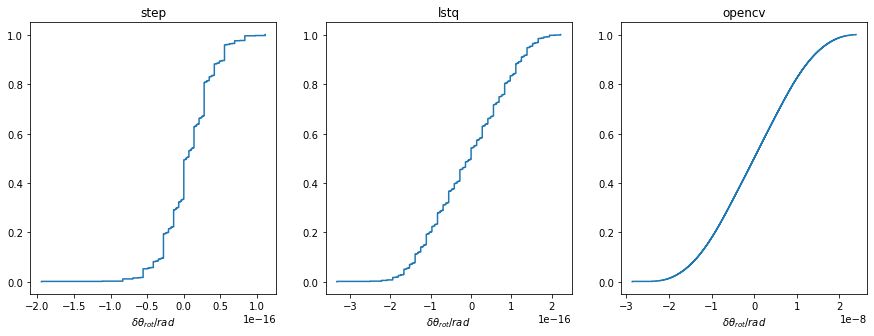

In [14]:
# analysis the absolute difference in rotatio angle

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   d_thetas_step,
    'lstq':   d_thetas_lstq,
    'opencv': d_thetas_cv02,
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta\theta_{rot} / rad$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_theta_abs.pdf', bbox_inches='tight', pad_inches = 0.01)

All three methods can pretty accurately recovering the rotation angle.

> NOTE: opencv using single precision, therefore limiting its accuracy to 1e-8 whereas the other methods can reach 1e-16 thanks to the double precision.

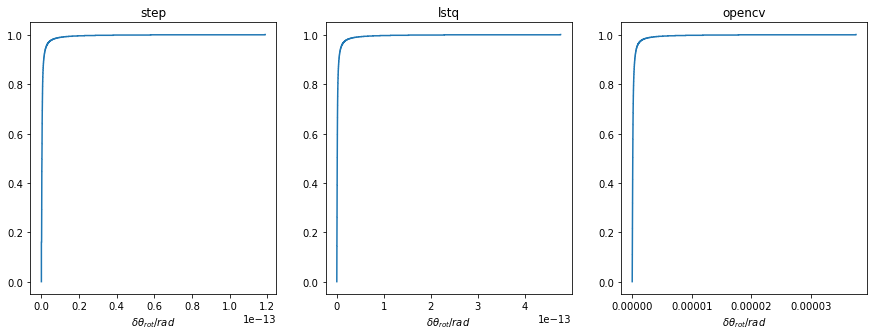

In [15]:
# analysis of the relative difference in rotation angles

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.absolute(d_thetas_step/thetas),
    'lstq':   np.absolute(d_thetas_lstq/thetas),
    'opencv': np.absolute(d_thetas_cv02/thetas),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta\theta_{rot} / rad$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_theta_rel.pdf', bbox_inches='tight', pad_inches = 0.01)

From the relative deviation, the rotation angle recovered is still pretty accurate.

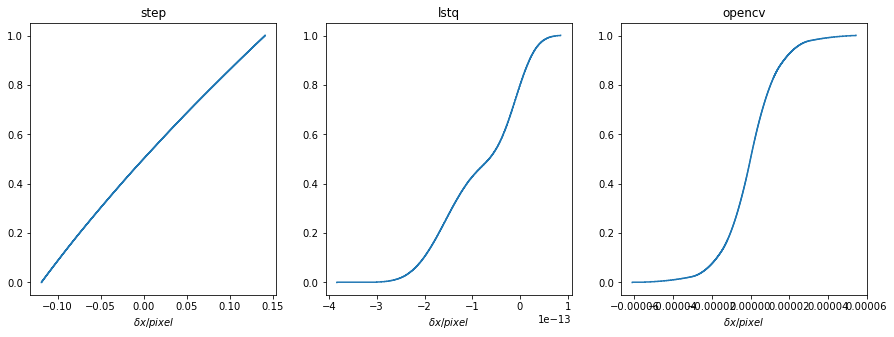

In [16]:
# analysis of the absolute error in recovered translation

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   d_trnls_step.flatten(),
    'lstq':   d_trnls_lstq.flatten(),
    'opencv': d_trnls_cv02.flatten(),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta x / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_trnls_abs.pdf', bbox_inches='tight', pad_inches = 0.01)

It seems like __step method__ is not very good at recovering the translation.  Based on the analysis, the least-square regression based method provides the most accurate results.

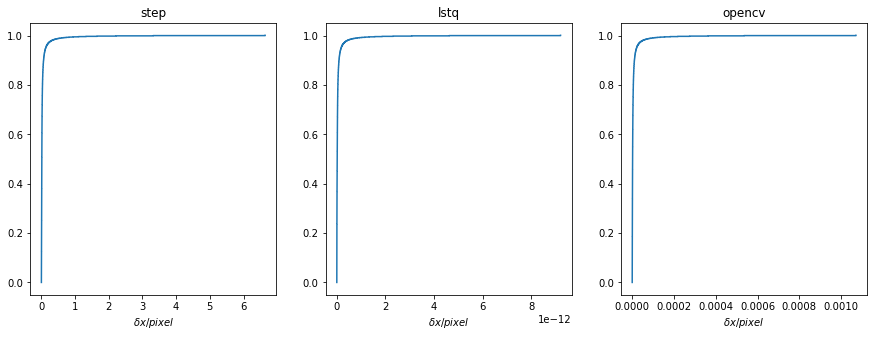

In [17]:
# analysis of the absolute error in recovered translation

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.absolute(d_trnls_step/trnls).flatten(),
    'lstq':   np.absolute(d_trnls_lstq/trnls).flatten(),
    'opencv': np.absolute(d_trnls_cv02/trnls).flatten(),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta x / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_trnls_rel.pdf', bbox_inches='tight', pad_inches = 0.01)

Based on the analysis above, the least-sqaure regression based method is best suited for identifying the detector drifting in ideal conditions (no noises).

## Non-ideal cases with added noises

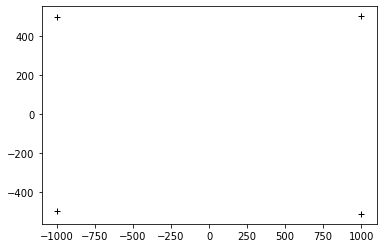

In [18]:
# mimic a 2k detector with imperfect slits

cnrs = np.array([
    [-1000, 500],
    [-998, -495],
    [1000, -510],
    [ 995,  502],
], dtype=float)

plt.plot(cnrs[:,0], cnrs[:,1], 'k+')

In [19]:
N = 1000000  # total number of cases

thetas = np.radians((np.random.random(N)-0.5)*2*10)  # +- 10 degrees of rotation in detector drifting
trnls  = (np.random.random((N, 2))-0.5)*2*10         # assume the detector will note drift more than 10 pixels
noises = (np.random.random((N, 2))-0.5)*2*2          # assume maximum two pixels noises

d_thetas_step = np.zeros(N)
d_thetas_lstq = np.zeros(N)
d_thetas_cv02 = np.zeros(N)

d_trnls_step = np.zeros((N,2))
d_trnls_lstq = np.zeros((N,2))
d_trnls_cv02 = np.zeros((N,2))

get_ang = lambda m: np.arctan2(m[1,0], m[0,0])

for i in tqdm_notebook(range(N)):
    # input drifting paras
    theta = thetas[i]
    trnl  = trnls[i, :]
    noise = noises[i, :]
    
    # get the drifted corners
    cnrs_tgt = np.dot(get_rotm(theta), cnrs.T).T + trnl + noise
    
    # step method
    m = get_transformation(cnrs, cnrs_tgt)
    d_thetas_step[i]   = get_ang(m) - theta
    d_trnls_step[i, :] = m[:,-1].T - trnl
    
    # least-square method
    m = calc_affine_transform(cnrs, cnrs_tgt)[:2, :]
    d_thetas_lstq[i]  = get_ang(m) - theta
    d_trnls_lstq[i,:] = m[:,-1].T - trnl
    
    # opencv method
    m = cv2.getAffineTransform(cnrs.astype(np.float32)[:3,:], 
                               cnrs_tgt.astype(np.float32)[:3,:],
                              )  # open cv only takes 3 points, so we are taking the first 3
    d_thetas_cv02[i]  = get_ang(m) - theta
    d_trnls_cv02[i,:] = m[:,-1].T - trnl


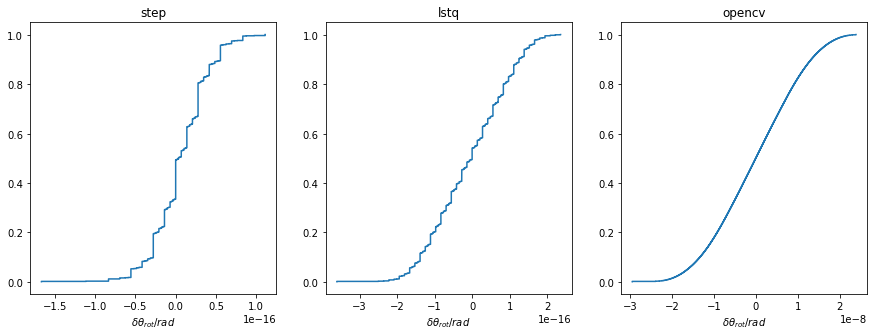

In [20]:
# analysis the absolute difference in rotatio angle

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   d_thetas_step,
    'lstq':   d_thetas_lstq,
    'opencv': d_thetas_cv02,
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta\theta_{rot} / rad$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_theta_abs_nonideal.pdf', bbox_inches='tight', pad_inches = 0.01)

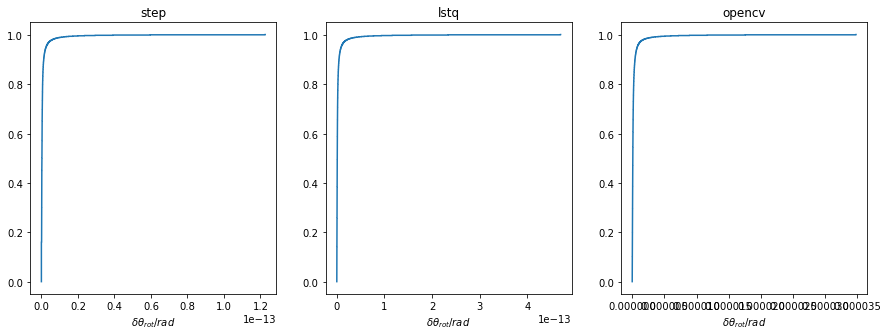

In [21]:
# analysis of the relative difference in rotation angles

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.absolute(d_thetas_step/thetas),
    'lstq':   np.absolute(d_thetas_lstq/thetas),
    'opencv': np.absolute(d_thetas_cv02/thetas),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta\theta_{rot} / rad$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_theta_rel_nonideal.pdf', bbox_inches='tight', pad_inches = 0.01)

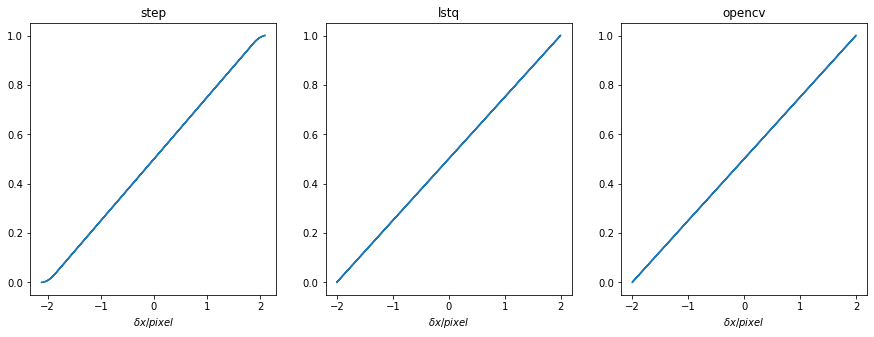

In [22]:
# analysis of the absolute error in recovered translation

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   d_trnls_step.flatten(),
    'lstq':   d_trnls_lstq.flatten(),
    'opencv': d_trnls_cv02.flatten(),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta x / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_trnls_abs_nonideal.pdf', bbox_inches='tight', pad_inches = 0.01)

seems like the error is purely in the added noises

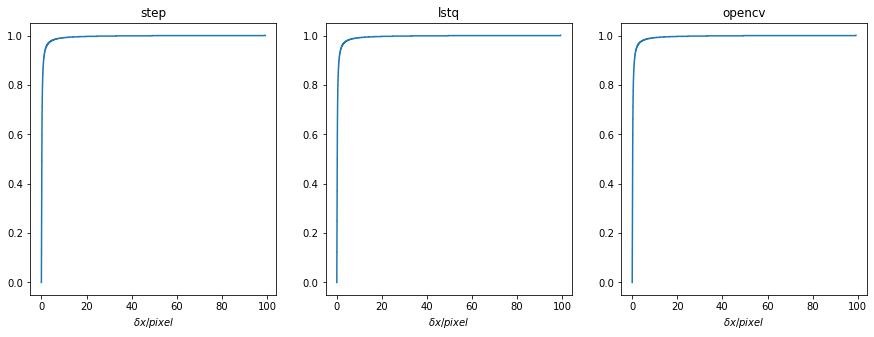

In [23]:
# analysis of the absolute error in recovered translation

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.absolute(d_trnls_step/trnls).flatten(),
    'lstq':   np.absolute(d_trnls_lstq/trnls).flatten(),
    'opencv': np.absolute(d_trnls_cv02/trnls).flatten(),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$\delta x / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_delta_trnls_rel_nonideal.pdf', bbox_inches='tight', pad_inches = 0.01)

So it seems none of the methods is resistant to the added noises.  In other words, all three methods are very sensitive to the error in the corner detection step.

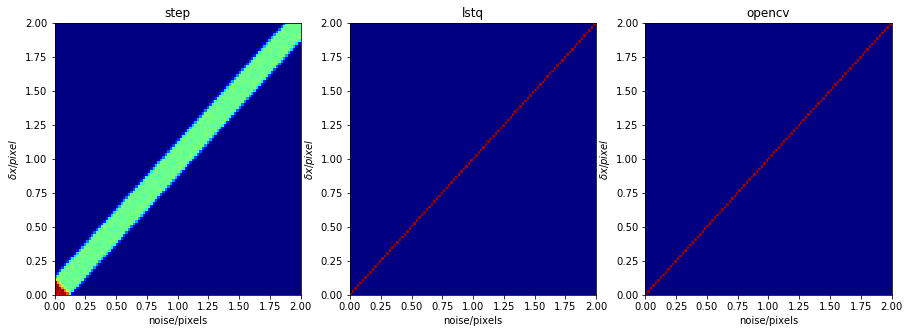

In [24]:
# analysis of the absolute error in recovered translation

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   d_trnls_step.flatten(),
    'lstq':   d_trnls_lstq.flatten(),
    'opencv': d_trnls_cv02.flatten(),
}

for i, lb in enumerate(plt_dict.keys()):
    ax[i].hist2d(np.absolute(noises.flatten()), np.absolute(plt_dict[lb]), bins=100, cmap='jet')
    ax[i].set_xlabel('noise/pixels')
    ax[i].set_ylabel(r'$\delta x / pixel$')
    ax[i].set_title(lb)
    ax[i].set_xlim(0,2)
    ax[i].set_ylim(0,2)
    
plt.savefig('hist2d_noise-delta_trnls_abs_nonideal.pdf', bbox_inches='tight', pad_inches = 0.01)

The linear relationship bewteen the added noises (error in corner detection) and the error in calculated translation shows that it is critical to improve the corner detection whereas the least-square and the opencv methods are robust enough for production usage.

# Uncertainty in the rotation center

Up to this point, the rotation center is always in the center of the image, whihc might not be the cases in real application.  Now we are going to set up a random rotation center, and see if we can still get the correct rotation angle and translation back...

In [25]:
cnrs = np.array([
    [2, 1],
    [-2, 1],
    [-2, -1],
    [2, -1],
])

rot_cnt = np.array([10, 20])

theta = np.radians(5)
rot = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)],
])
cnrs_rotted = np.dot(rot, (cnrs-rot_cnt).T).T + rot_cnt

trns = np.random.random((1, 2))*0.2
cnrs_rotted_shiftted = cnrs_rotted + trns

level = 0.01  # 1% of noise
noise = np.random.random(cnrs.shape)*level
cnrs_tgt = cnrs_rotted_shiftted + noise

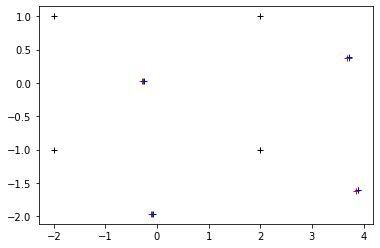

In [26]:
plt.plot(cnrs[:,0], cnrs[:,1], 'k+')

plt.plot(cnrs_rotted[:,0], cnrs_rotted[:,1], 'r+')

plt.plot(cnrs_rotted_shiftted[:,0], cnrs_rotted_shiftted[:,1], 'g+')

plt.plot(cnrs_tgt[:,0], cnrs_tgt[:,1], 'b+')

In [27]:
# separated method

m_1 = get_transformation(cnrs, cnrs_tgt)
m_2 = calc_affine_transform(cnrs, cnrs_tgt)[:2, :]
m_3 = cv2.getAffineTransform(cnrs.astype(np.float32)[:3,:], cnrs_tgt.astype(np.float32)[:3,:])

print(f"step method:\n{m_1}")
print(f"least square:\n{m_2}")
print(f"{calc_affine_transform(cnrs, cnrs_tgt)}")
print(f"open cv:\n{m_3}")

step method:
[[ 0.99612103 -0.08635153  1.81814166]
 [ 0.08794838  0.99753524 -0.78654831]]
least square:
[[ 0.99612103 -0.08635153  1.81814166]
 [ 0.08794838  0.99753524 -0.78654831]]
[[ 9.96121027e-01 -8.63515266e-02  1.81814166e+00]
 [ 8.79483823e-02  9.97535239e-01 -7.86548312e-01]
 [ 2.77555756e-17 -1.70234197e-16  1.00000000e+00]]
open cv:
[[ 0.9964995  -0.08710846  1.8188986 ]
 [ 0.08806181  0.99730841 -0.78632148]]


In [28]:
theta_1 = np.arctan2(m_1[1,0], m_1[0,0])
theta_2 = np.arctan2(m_2[1,0], m_2[0,0])
theta_3 = np.arctan2(m_3[1,0], m_3[0,0])

trns_1 = m_1[:,-1].T
trns_2 = m_2[:,-1].T
trns_3 = m_3[:,-1].T

print("step method:")
print(f"{theta_1} - {theta} = {theta_1-theta}")
print(f"{trns_1} - {trns} = {trns_1-trns} ")

print("least square:")
print(f"{theta_2} - {theta} = {theta_2-theta}")
print(f"{trns_2} - {trns} = {trns_2-trns} ")

print("opencv:")
print(f"{theta_3} - {theta} = {theta_3-theta}")
print(f"{trns_3} - {trns} = {trns_3-trns} ")


step method:
0.08806250998311534 - 0.08726646259971647 = 0.0007960473833988624
[ 1.81814166 -0.78654831] - [[0.03067817 0.00289173]] = [[ 1.78746349 -0.78944004]] 
least square:
0.08806250998311532 - 0.08726646259971647 = 0.0007960473833988485
[ 1.81814166 -0.78654831] - [[0.03067817 0.00289173]] = [[ 1.78746349 -0.78944004]] 
opencv:
0.08814218554795902 - 0.08726646259971647 = 0.0008757229482425494
[ 1.8188986  -0.78632148] - [[0.03067817 0.00289173]] = [[ 1.78822043 -0.78921321]] 


Non-central rotation center clearly poses a huge issue for correctly detecting the translation...

In [29]:
np.dot(m_2, np.vstack((cnrs.T, np.ones((1,cnrs.shape[0]))))).T - cnrs_rotted_shiftted

array([[0.00695249, 0.00893717],
       [0.00724717, 0.00576661],
       [0.00563874, 0.00308553],
       [0.00534406, 0.00625608]])

In [30]:
cnrs_rotted_shiftted

array([[ 3.71707969,  0.37794653],
       [-0.2676991 ,  0.02932355],
       [-0.09338761, -1.96306584],
       [ 3.89139118, -1.61444287]])

In [31]:
cnrs_tgt

array([[ 3.72478912,  0.38711055],
       [-0.26120886,  0.0348633 ],
       [-0.08699194, -1.95975346],
       [ 3.8959783 , -1.60841364]])

So it seems like with a non-standard rotation center, it is no longer possible to directly extract the translation from the calculated affine transformation matrix, even if the matrix is still capable of transforming the points to the correct location.

## Testing without added noises

Assume perfect corner detection.

Also, since the rotation center is these cases are no longer at the center of the image (0,0), we can no longer directly read out the correct translation value from the affine transformation matrix.  Instead, we are going to generate additional data points for cross validation.

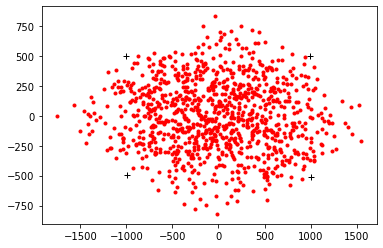

In [41]:
# mimic a 2k detector with imperfect slits

cnrs = np.array([
    [-1000, 500],
    [-998, -495],
    [1000, -510],
    [ 995,  502],
], dtype=float)

plt.plot(cnrs[:,0], cnrs[:,1], 'k+')

n_test = 1000
pts_test = np.dot(np.random.random(n_test*4).reshape(n_test, 4), cnrs)

plt.plot(pts_test[:,0], pts_test[:,1], 'r.')

In [42]:
N = 1000000  # total number of cases

thetas = np.radians((np.random.random(N)-0.5)*2*10)  # +- 10 degrees of rotation in detector drifting
trnls  = (np.random.random((N, 2))-0.5)*2*10         # assume the detector will note drift more than 10 pixels
rotcnts = (np.random.random((N, 2))-0.5)*2*2000      # rotation center can be anywhere

errs_step = np.zeros((N, n_test))  # errors in reconvering the correct location...
errs_lstq = np.zeros((N, n_test))
errs_cv02 = np.zeros((N, n_test))

# transform points with given affine transformation matrix
tran_pts = lambda m, pts: np.dot(m, np.vstack((pts.T, np.ones((1,pts.shape[0]))))).T

for i in tqdm_notebook(range(N)):
    # input drifting paras
    theta = thetas[i]
    trnl  = trnls[i, :]
    rotcnt = rotcnts[i, :]
    
    # get the drifted corners
    cnrs_tgt = (np.dot(get_rotm(theta), (cnrs-rotcnt).T).T +rotcnt) + trnl
    
    # get the drifted testing pts (the correct location)
    pts_tgt = (np.dot(get_rotm(theta), (pts_test-rotcnt).T).T +rotcnt) + trnl
    
    # step method
    m = get_transformation(cnrs, cnrs_tgt)
    errs_step[i,:] = np.linalg.norm(
        tran_pts(m, pts_test) - pts_tgt,
        axis=1,
    )
    
    # least-square method
    m = calc_affine_transform(cnrs, cnrs_tgt)[:2, :]
    errs_lstq[i,:] = np.linalg.norm(
        tran_pts(m, pts_test) - pts_tgt,
        axis=1,
    )
    
    # opencv method
    m = cv2.getAffineTransform(cnrs.astype(np.float32)[:3,:], 
                               cnrs_tgt.astype(np.float32)[:3,:],
                              )  # open cv only takes 3 points, so we are taking the first 3
    errs_cv02[i,:] = np.linalg.norm(
        tran_pts(m, pts_test) - pts_tgt,
        axis=1,
    )


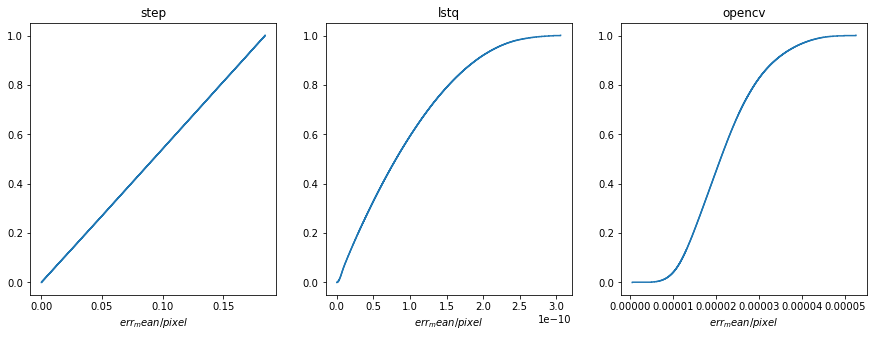

In [43]:
# analysis the absolute difference in rotatio angle

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.average(errs_step, axis=1),
    'lstq':   np.average(errs_lstq, axis=1),
    'opencv': np.average(errs_cv02, axis=1),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$err_mean / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_err_mean_abs_random-rotcnt.pdf', bbox_inches='tight', pad_inches = 0.01)

The step method was designed to have a rotation center between four points, so it is not surprising that it fails here.  However, it sees like both least square and the opencv method works find, with the least sqaure method working slighly better due to double precision.

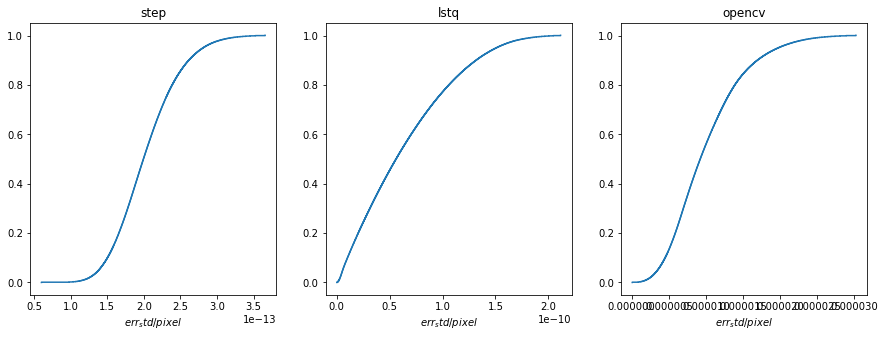

In [44]:
# analysis the absolute difference in rotatio angle

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.std(errs_step, axis=1),
    'lstq':   np.std(errs_lstq, axis=1),
    'opencv': np.std(errs_cv02, axis=1),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$err_std / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_err_std_abs_random-rotcnt.pdf', bbox_inches='tight', pad_inches = 0.01)

The performace for all three methods are very stable, which means we do not have to worry about things breaks down in special cases...

## Perform the test with noises

In [45]:
import gc
gc.collect()

301

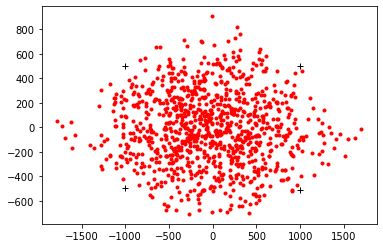

In [46]:
# mimic a 2k detector with imperfect slits

cnrs = np.array([
    [-1000, 500],
    [-998, -495],
    [1000, -510],
    [ 995,  502],
], dtype=float)

plt.plot(cnrs[:,0], cnrs[:,1], 'k+')

n_test = 1000
pts_test = np.dot(np.random.random(n_test*4).reshape(n_test, 4), cnrs)

plt.plot(pts_test[:,0], pts_test[:,1], 'r.')

In [47]:
N = 1000000  # total number of cases

thetas = np.radians((np.random.random(N)-0.5)*2*10)  # +- 10 degrees of rotation in detector drifting
trnls  = (np.random.random((N, 2))-0.5)*2*10         # assume the detector will note drift more than 10 pixels
rotcnts = (np.random.random((N, 2))-0.5)*2*2000      # rotation center can be anywhere
noises = (np.random.random((N, 2))-0.5)*2*2          # assume maximum two pixels noises

errs_step = np.zeros((N, n_test))  # errors in reconvering the correct location...
errs_lstq = np.zeros((N, n_test))
errs_cv02 = np.zeros((N, n_test))

# transform points with given affine transformation matrix
tran_pts = lambda m, pts: np.dot(m, np.vstack((pts.T, np.ones((1,pts.shape[0]))))).T

for i in tqdm_notebook(range(N)):
    # input drifting paras
    theta = thetas[i]
    trnl  = trnls[i, :]
    rotcnt = rotcnts[i, :]
    noise = noises[i, :]
    
    # get the drifted corners
    cnrs_tgt = (np.dot(get_rotm(theta), (cnrs-rotcnt).T).T +rotcnt) + trnl + noise
    
    # get the drifted testing pts (the correct location)
    pts_tgt = (np.dot(get_rotm(theta), (pts_test-rotcnt).T).T +rotcnt) + trnl
    
    # step method
    m = get_transformation(cnrs, cnrs_tgt)
    errs_step[i,:] = np.linalg.norm(
        tran_pts(m, pts_test) - pts_tgt,
        axis=1,
    )
    
    # least-square method
    m = calc_affine_transform(cnrs, cnrs_tgt)[:2, :]
    errs_lstq[i,:] = np.linalg.norm(
        tran_pts(m, pts_test) - pts_tgt,
        axis=1,
    )
    
    # opencv method
    m = cv2.getAffineTransform(cnrs.astype(np.float32)[:3,:], 
                               cnrs_tgt.astype(np.float32)[:3,:],
                              )  # open cv only takes 3 points, so we are taking the first 3
    errs_cv02[i,:] = np.linalg.norm(
        tran_pts(m, pts_test) - pts_tgt,
        axis=1,
    )


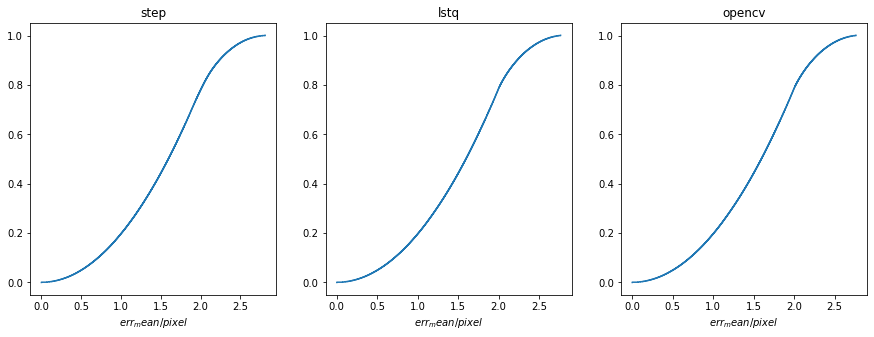

In [48]:
# analysis the absolute difference in rotatio angle

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.average(errs_step, axis=1),
    'lstq':   np.average(errs_lstq, axis=1),
    'opencv': np.average(errs_cv02, axis=1),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$err_mean / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_err_mean_abs_random-rotcnt_withNoise.pdf', bbox_inches='tight', pad_inches = 0.01)

similar to the previous results, the noise (error in the corner detection) is the dominate factor here.

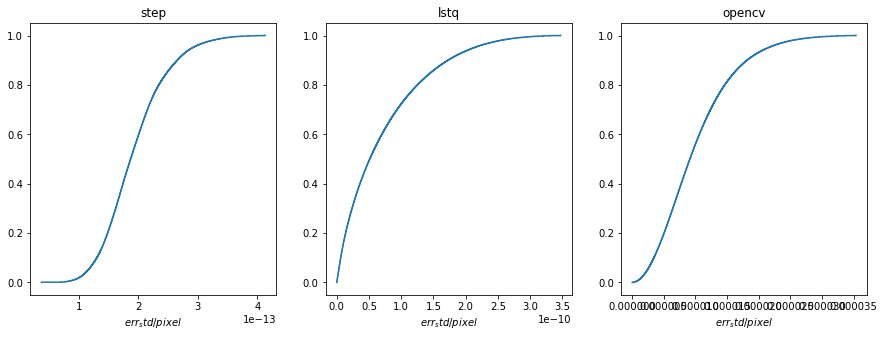

In [49]:
# analysis the absolute difference in rotatio angle

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.std(errs_step, axis=1),
    'lstq':   np.std(errs_lstq, axis=1),
    'opencv': np.std(errs_cv02, axis=1),
}

for i, lb in enumerate(plt_dict.keys()):
    xx, yy = discrete_cdf(plt_dict[lb], steps=1000)
    ax[i].plot(xx, yy)
    ax[i].set_xlabel(r'$err_std / pixel$')
    ax[i].set_title(lb)

plt.savefig('cdf_err_std_abs_random-rotcnt_withNoise.pdf', bbox_inches='tight', pad_inches = 0.01)

results are stable regardless of noise

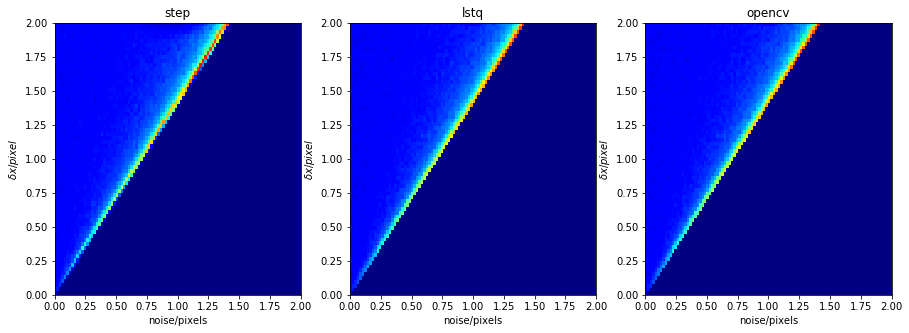

In [50]:
# analysis of the absolute error in recovered translation

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt_dict = {
    'step':   np.average(errs_step, axis=1),
    'lstq':   np.average(errs_lstq, axis=1),
    'opencv': np.average(errs_cv02, axis=1),
}

for i, lb in enumerate(plt_dict.keys()):
    ax[i].hist2d(np.absolute(np.average(noises, axis=1)), 
                 np.absolute(plt_dict[lb]), 
                 bins=100, cmap='jet')
    ax[i].set_xlabel('noise/pixels')
    ax[i].set_ylabel(r'$\delta x / pixel$')
    ax[i].set_title(lb)
    ax[i].set_xlim(0,2)
    ax[i].set_ylim(0,2)
    
plt.savefig('hist2d_noise-err_abs_random-rotcnt_withNoise.pdf', bbox_inches='tight', pad_inches = 0.01)

Interestingly enough, none of the three methods can help reduce the negative impact from noise.  Furthermore, unlike the cases with fixed rotation center, the error will only increses.

> Basically the same story: the detection of the slit corner is extremely important.